# **PROBLEM STATEMENT**
# Develop a predictive model to classify medicines into one of three categories — optimal, semi-optimal, or poor — based on user reviews. The goal is to analyze the text of medicine reviews and predict the quality class of each medicine.

# **DATASET DESCRIPTION**
The dataset provides patient reviews on specific drugs along with related conditions and a  patient rating reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites. The intention was to study  sentiment analysis of drug experience over multiple facets, i.e. sentiments learned on specific aspects such as effectiveness and side effects.

1. **drugName** (categorical): name of drug
2. **condition** (categorical): name of condition
3. **review** (text): patient review
4. **rating** (numerical): 10 star patient rating
5. **date** (date): date of review entry
6. **usefulCount** (numerical): number of users who found review useful


In [46]:
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,KFold,cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('drugsComTrain_raw.tsv',sep='\t')

# **EDA**

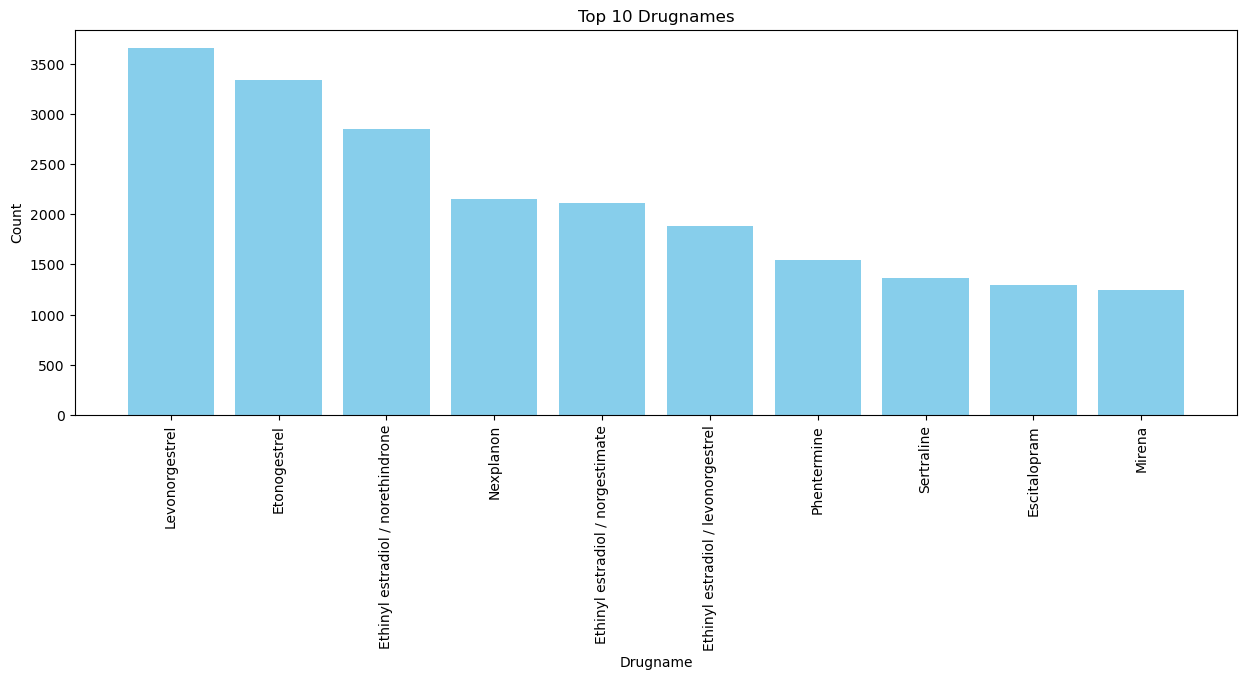

In [3]:
top_10_drugcount=df['drugName'].value_counts().head(10)
plt.figure(figsize=(15,5))
plt.bar(top_10_drugcount.index,top_10_drugcount.values,color='skyblue')
plt.xlabel('Drugname')
plt.ylabel('Count')
plt.title('Top 10 Drugnames')
plt.xticks(rotation=90)
plt.show()

Here we can see how the drug names are being repeated, and what their frequency is

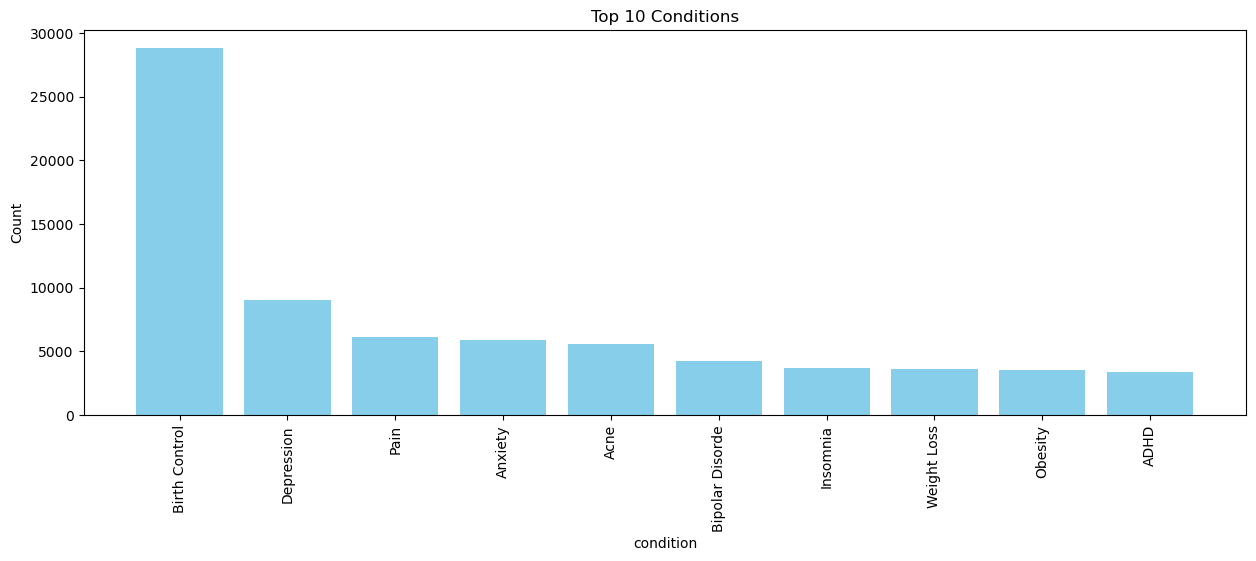

In [6]:
top_10_condition_count=df['condition'].value_counts().head(10)
plt.figure(figsize=(15,5))
plt.bar(top_10_condition_count.index,top_10_condition_count.values,color='skyblue')
plt.xlabel('condition')
plt.ylabel('Count')
plt.title('Top 10 Conditions')
plt.xticks(rotation=90)
plt.show()

We can see how 'Birth control' is dominating in number of conditions

In [7]:
df['review'] = df['review'].astype(str)

c:\Users\Mihir\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


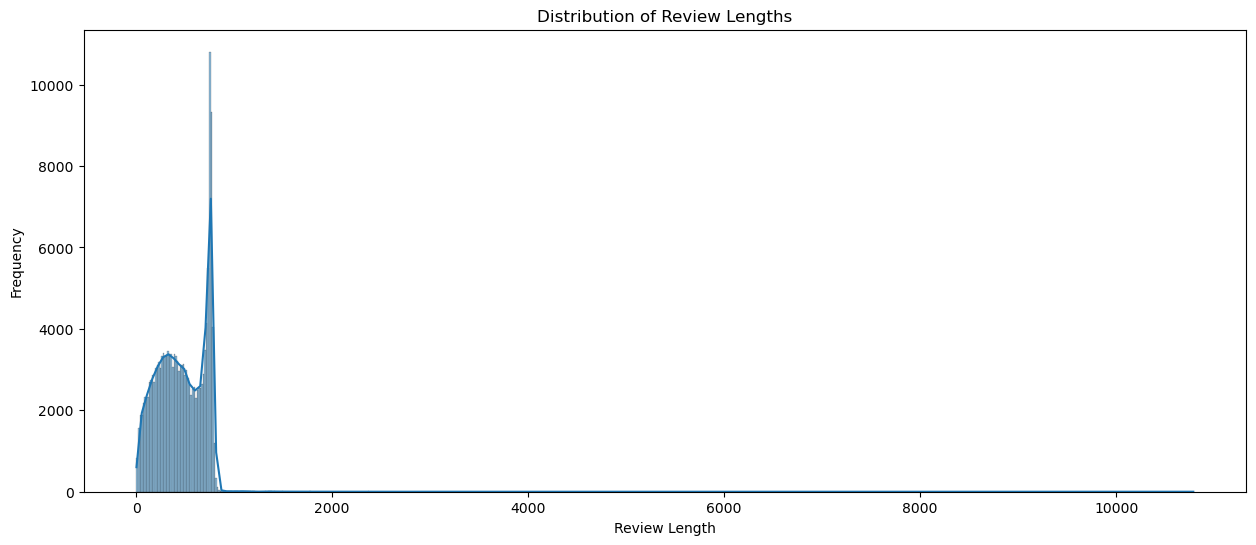

In [8]:

arr = df['review'].apply(len)
plt.figure(figsize=(15, 6))
sns.histplot(arr, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

Here we can see that majority reviews are between 500-1000 words, while some reviews are significantly longer
Also note that the distribution is bimodal

c:\Users\Mihir\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


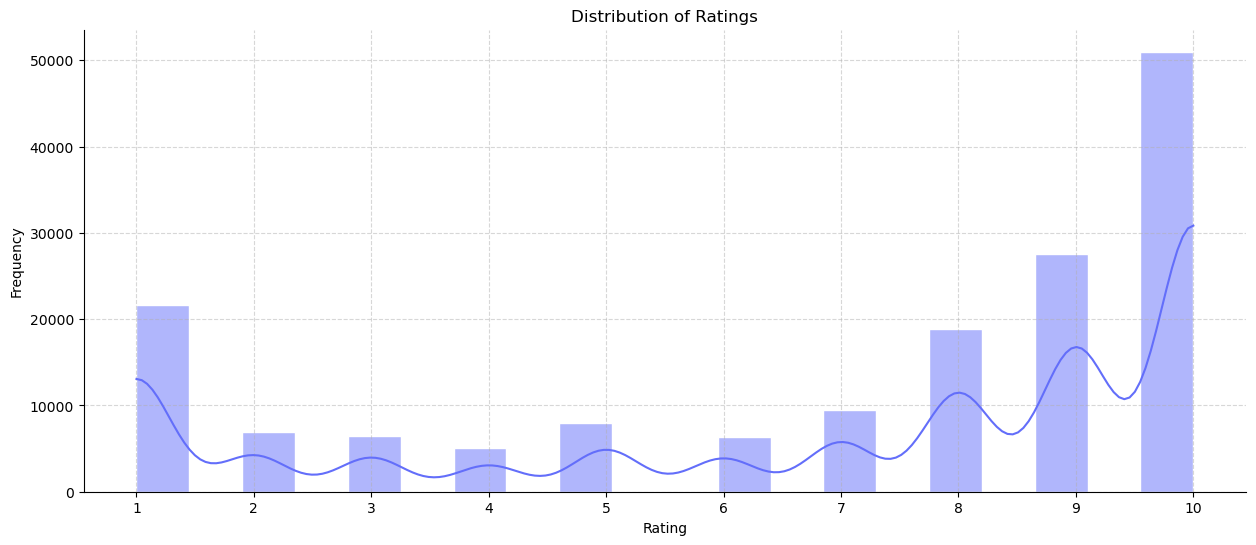

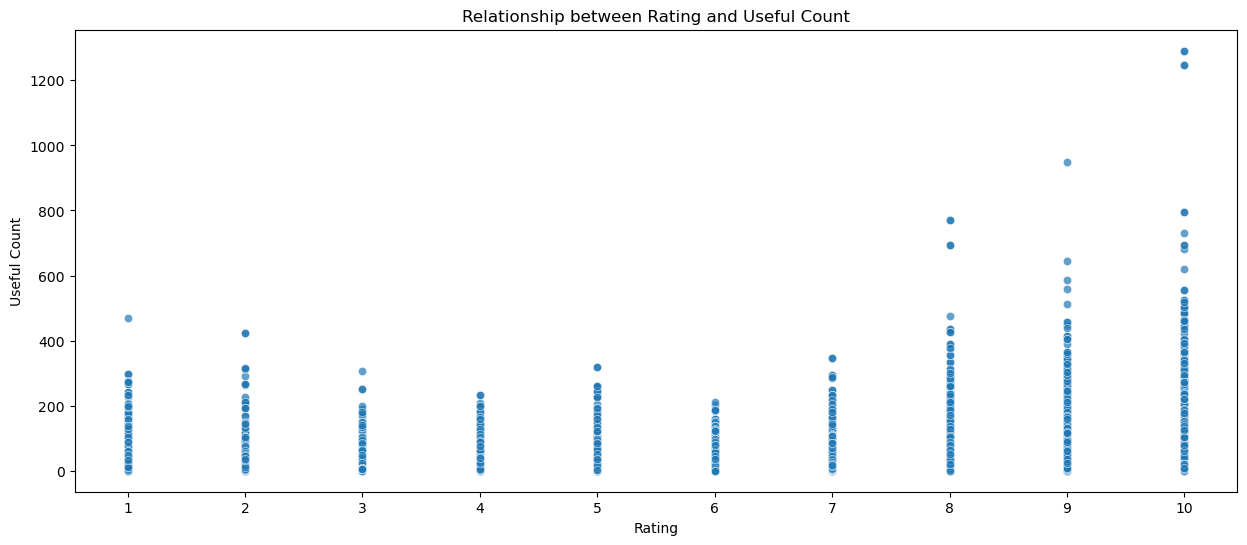

In [9]:
plt.figure(figsize=(15, 6))
sns.histplot(df['rating'], bins=20, kde=True, color='#636EFA', edgecolor='white')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.xticks(range(1, 11))
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()
plt.show()

plt.figure(figsize=(15, 6))
scatter = sns.scatterplot(x='rating', y='usefulCount', data=df,
                            sizes=(20, 200), alpha=0.7)

plt.title('Relationship between Rating and Useful Count')
plt.xlabel('Rating')
plt.ylabel('Useful Count')
plt.xticks(range(1, 11))

plt.show()


1. Here we can see that the ratings are distributed bimodally with them being more distributed to either end, 
2. This makes sense as people are more likely to review when either the drug performs very well or very badly, and since more drugs perform better, it is skewed as well

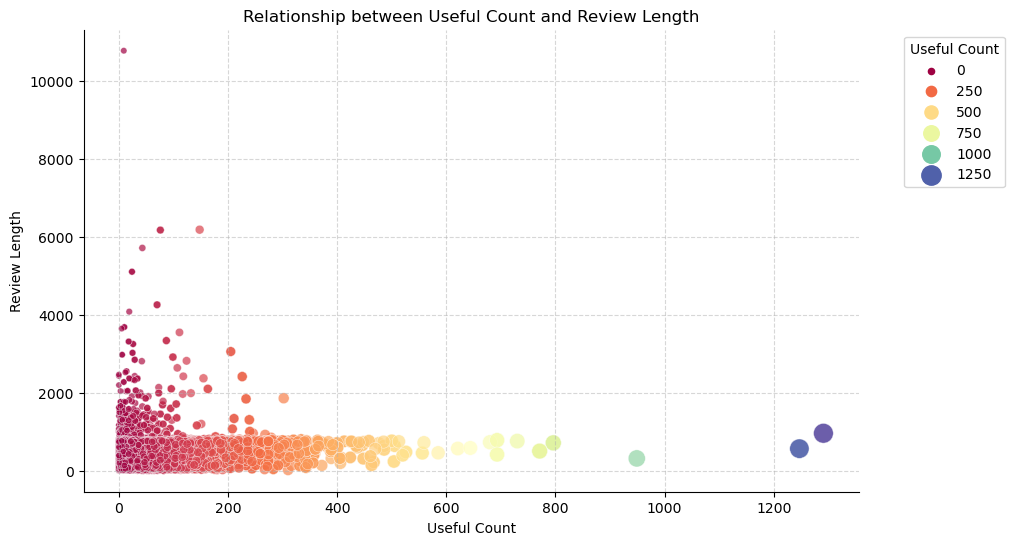

In [10]:
plt.figure(figsize=(10, 6))
scatter2 = sns.scatterplot(x='usefulCount', y=arr, data=df,
                           hue='usefulCount', palette='Spectral',
                           size='usefulCount', sizes=(20, 200), alpha=0.7)


plt.title('Relationship between Useful Count and Review Length')
plt.xlabel('Useful Count')
plt.ylabel('Review Length')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Useful Count')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Here we can see that most of the reviews that were considered useful, were between 500 to 1000 words, which makes sense as shorter reviews may not go into more detail, and longer reviews may end up being garrulous


# **BASIC PREPROCESSING**

In [4]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [5]:
df = df.drop(columns=['Unnamed: 0','drugName','date','condition'])

 Converting rating(an ordinal feature) into 3 classes,in the following order:

  1.Optimal Medicine

  2.Semi-Optimal Medicine

  3.Poor Medicine

In [6]:
def convert_rating_to_class(data):

    if data >= 7:
        return 'Optimal Medicine'
    elif data >= 5 and data <= 7:
        return 'Semi-Optimal Medicine'
    else:
        return 'Poor Medicine'

df['rating'] = df['rating'].apply(convert_rating_to_class)

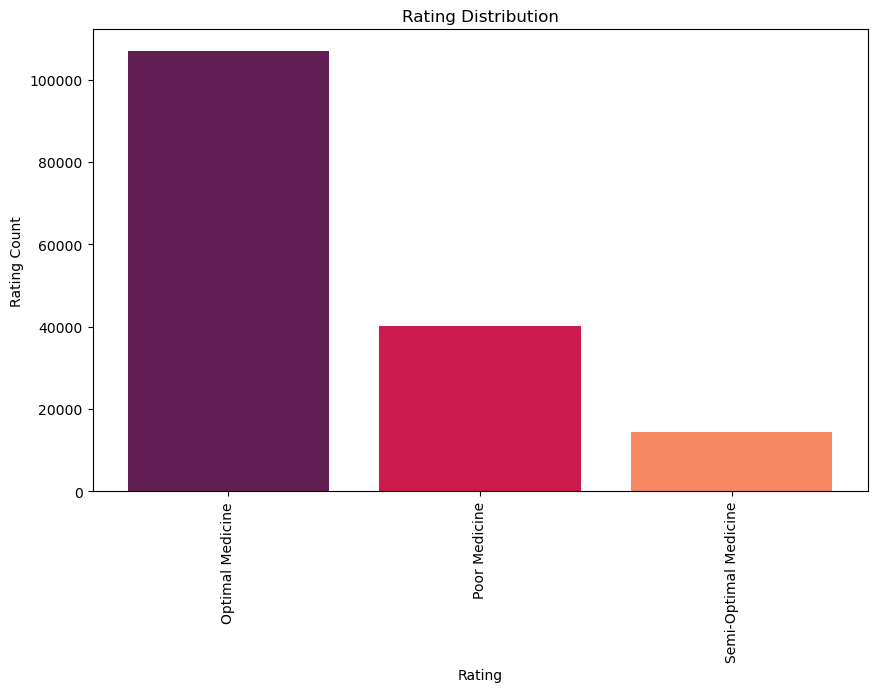

In [7]:
plt.figure(figsize=(10,6))
values = dict(df['rating'].value_counts())
keys = values.keys()
count = values.values()
color = sns.color_palette('rocket',n_colors=len(keys))
plt.bar(keys,count,color = color)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Rating Count')
plt.xticks(rotation=90)
plt.show()

Here we can see that most of the reviews that were considered useful, were between 500 to 1000 words, which makes sense as shorter reviews may not go into more detail, and longer reviews may end up being garrulous

In [8]:
df.head()

,review,rating,usefulCount
0,"""It has no side effect, I take it in combinati...",Optimal Medicine,27
1,"""My son is halfway through his fourth week of ...",Optimal Medicine,192
2,"""I used to take another oral contraceptive, wh...",Semi-Optimal Medicine,17
3,"""This is my first time using any form of birth...",Optimal Medicine,10
4,"""Suboxone has completely turned my life around...",Optimal Medicine,37


# **HANDLING TEXT DATA BY PERFORMING NATURAL LANGUAGE PROCESSING**

**The feature in our focus is the "review" feature which contains the reviews of various patients/users who have taken a certain medicine.**

In [9]:
df['review']

0         "It has no side effect, I take it in combinati...
1         "My son is halfway through his fourth week of ...
2         "I used to take another oral contraceptive, wh...
3         "This is my first time using any form of birth...
4         "Suboxone has completely turned my life around...
                                ...                        
161292    "I wrote my first report in Mid-October of 201...
161293    "I was given this in IV before surgey. I immed...
161294    "Limited improvement after 4 months, developed...
161295    "I&#039;ve been on thyroid medication 49 years...
161296    "I&#039;ve had chronic constipation all my adu...
Name: review, Length: 161297, dtype: object

# **Text Preprocessing**

## CONVERTING TEXT INTO LOWERCASE FOR THE FOLLOWING REASONS:

1.  Case Insensitivity: To avoid case-based discrepancies.
2.  Reduces Vocabulary Size: Lowercasing reduces the number of unique words (tokens), simplifying the model and improving efficiency.
3. Consistency in Tokenization: It ensures uniform tokenization, preventing inconsistent feature representations for the same word with different cases.
4. Improves Text Matching: Helps in search and retrieval tasks


In [10]:
df['review'] = df['review'].str.lower()

In [11]:
df['review']

0         "it has no side effect, i take it in combinati...
1         "my son is halfway through his fourth week of ...
2         "i used to take another oral contraceptive, wh...
3         "this is my first time using any form of birth...
4         "suboxone has completely turned my life around...
                                ...                        
161292    "i wrote my first report in mid-october of 201...
161293    "i was given this in iv before surgey. i immed...
161294    "limited improvement after 4 months, developed...
161295    "i&#039;ve been on thyroid medication 49 years...
161296    "i&#039;ve had chronic constipation all my adu...
Name: review, Length: 161297, dtype: object

# Handling Punctuation
1. Reduces Noise: Punctuation marks like commas, periods, and exclamation points often don’t contribute meaningfully to the text and can introduce noise in text processing.

2. Improves Tokenization: Removing punctuation improves the quality of tokenization by separating meaningful words, which helps in generating cleaner and more useful tokens.

3. Enhances Feature Representation: By removing punctuation, the focus shifts to more important textual features (words), which can improve the model's ability to capture meaningful patterns in the data.

4. Reduces Overfitting: Models might overfit to specific punctuation patterns that are irrelevant. Removing punctuation helps the model generalize better by focusing on the actual content.

5. Increases Processing Speed: Eliminating unnecessary punctuation reduces the dataset size, leading to faster processing times, especially in large-scale text analysis tasks.

6. Simplifies Interpretation: Without punctuation marks cluttering the text, it becomes easier to interpret and visualize the results in tasks like sentiment analysis or classification.

In [12]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

## In string library we can see all punctuation. removing this all punctuations that may not contribute to review feature

In [13]:
def remove_punctuation(data):
    stop_words = string.punctuation
    for word in stop_words:
        data = data.replace(word, '')
    return data

df['review'] = df['review'].apply(remove_punctuation)

In [14]:
df['review']

0         it has no side effect i take it in combination...
1         my son is halfway through his fourth week of i...
2         i used to take another oral contraceptive whic...
3         this is my first time using any form of birth ...
4         suboxone has completely turned my life around ...
                                ...                        
161292    i wrote my first report in midoctober of 2014 ...
161293    i was given this in iv before surgey i immedia...
161294    limited improvement after 4 months developed b...
161295    i039ve been on thyroid medication 49 years i s...
161296    i039ve had chronic constipation all my adult l...
Name: review, Length: 161297, dtype: object

## Removing pronouns

In [15]:
def remove_pronoun(data):

    pattern = r'\b(I|Me|My|Mine|Myself|You|Your|Yours|Yourself|He|Him|His|Himself|She|Her|Hers|Herself|It|Its|Itself|We)+\b'

    return re.sub(pattern,'',data,flags=re.IGNORECASE)

df['review'] = df['review'].apply(remove_pronoun)

## Due to the presence of some unusual patterns like 'i\&\#039;', we will remove them as they don\'t provide any meaning.

In [16]:
def handling_pattern(data):
    data = str(data)
    pattern = r'i&#039'
    temp = re.sub(pattern, '', data)
    return temp.replace('1','')

df['review'] = df['review'].apply(handling_pattern)

In [17]:
df.head()

,review,rating,usefulCount
0,has no side effect take in combination of b...,Optimal Medicine,27
1,son is halfway through fourth week of intuni...,Optimal Medicine,192
2,used to take another oral contraceptive which...,Semi-Optimal Medicine,17
3,this is first time using any form of birth co...,Optimal Medicine,10
4,suboxone has completely turned life around ...,Optimal Medicine,37


# USING **PUNKT**
The Punkt package in NLTK (Natural Language Toolkit) is a pre-trained model that helps with sentence tokenization and word tokenization. It is specifically designed to handle the intricacies of splitting text into sentences and words, even when there are ambiguities due to punctuation.


In [18]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mihir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# USING **WORDNET**
The WordNet package in NLTK is a large lexical database of English, which is used for natural language processing (NLP) tasks. It helps with understanding the relationships between words and their meanings.

-Provides Synonyms (Synsets): WordNet groups words into sets of synonyms (called synsets), which represent distinct concepts or meanings of a word.

-Word Relationships: It defines relationships between words, such as:

Hypernyms: General terms

Hyponyms: More specific terms

Antonyms: Opposite meanings

Holonyms and Meronyms: Part-whole relationships

-Word Sense Disambiguation: WordNet helps disambiguate the meaning of a word in different contexts by identifying the correct synset.

In [19]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mihir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Mihir\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Reducing words to their base form and using lemmetization as it:

Standardizes Word Forms: Lemmatization reduces words to their base or root form, ensuring that different forms of a word

Improves Text Consistency: It makes the text more uniform by converting inflected words to their dictionary forms, simplifying analysis.

Reduces Vocabulary Size: By reducing words to their root form, lemmatization decreases the total number of unique words, making models more efficient.

Enhances Meaning: Unlike stemming, lemmatization uses context and grammar to derive the actual base form of a word, preserving the meaning and improving model accuracy.


In [20]:
def converting_to_base_word(data):

    lmt = WordNetLemmatizer()
    arr = word_tokenize(data)
    stemmed_word = [lmt.lemmatize(x) for x in arr]
    return ' '.join(stemmed_word)

df['review'] = df['review'].apply(converting_to_base_word)


In [21]:
df.head()

,review,rating,usefulCount
0,ha no side effect take in combination of bysto...,Optimal Medicine,27
1,son is halfway through fourth week of intuniv ...,Optimal Medicine,192
2,used to take another oral contraceptive which ...,Semi-Optimal Medicine,17
3,this is first time using any form of birth con...,Optimal Medicine,10
4,suboxone ha completely turned life around feel...,Optimal Medicine,37


## We have completed text preprocessing, and will now implement **feature extraction**

# **FEATURE EXTRACTION**

# **USING BAG OF WORDS(BoW)**
# Key Aspects of Bag of Words:

**Word Frequency Representation**:

The BoW technique represents a text document as a collection (or "bag") of its words, while disregarding grammar and word order.
Each word in the document is treated as an individual token, and its frequency (or presence) is recorded in a matrix.

**Vectorization:**

For a given corpus (collection of documents), a vocabulary (a list of unique words) is created.
Each document is then represented as a vector, where each entry in the vector corresponds to the frequency (or sometimes just the presence) of a word from the vocabulary in that document.

**The Bag of Words technique generates a document-term matrix where**:
Rows represent documents.
Columns represent words (terms) from the vocabulary.
Values in the matrix represent the word frequency or binary presence (1 if the word is present, 0 if not) in each document.

**Order-Independent:**

The technique ignores word order, treating documents as unordered "bags" of words.

In [29]:
df.isna().sum()

review         0
rating         0
usefulCount    0
dtype: int64

In [22]:
le = LabelEncoder()

df['rating'] = le.fit_transform(df['rating'])

# Performing a text classification task using a Logistic Regression model embedded in a Pipeline with a CountVectorizer for feature extraction. The goal is to predict ratings based on text reviews. It uses GridSearchCV to find the best parameters for the model and evaluates the model’s accuracy on the test data.
1. **CREATING PIPELINE**
**Pipeline**: Combines multiple steps into a single workflow, allowing data transformation and model training to be executed in sequence.

 -**CountVectorizer**: Converts the text reviews into a Bag of Words (BoW)
 representation by counting word frequencies, excluding English stopwords.

 -s**top_words**='english': Removes common English words (like "the", "and") that don't add much meaning.

 -**LogisticRegression**: A classification algorithm used for predicting the review rating. The settings are:

*   penalty='l2': L2 regularization to prevent overfitting.
*   max_iter=10000: Maximum number of iterations for the optimization solver.
*   C=0.5: Regularization strength
*   fit_intercept=True: Includes the intercept in the model.
*   n_jobs=-1: Uses all available processors to speed up training.
*   multi_class='ovr': One-vs-Rest (OvR) strategy for handling multiclass
   classification.   





**2.SPLITTING DATA**

train_test_split: Splits the dataset into training and test sets.

X: The text data (reviews).

y: The target variable (ratings).

test_size=0.2: 20% of the data is used for testing, while 80% is used for training.

random_state=42: Ensures the split is reproducible.





**3. Grid Search for Hyperparameter Tuning**

*Hyperparameter Grid (param_grid)* :

  -ngram_range: Considers different ranges of n-grams (individual words and sequences of 2 or 3 words).

  -min_df: Minimum document frequency (percentage of documents a word must appear in to be considered).

  -max_features: Limits the number of features (vocabulary size).

*GridSearchCV* :

Performs an exhaustive search over the parameter grid to find the best combination of parameters.

 -cv=5: 5-fold cross-validation is used to evaluate the model’s performance

 -across different data splits.

 -scoring='accuracy': Optimizes for the model with the best accuracy score.





**4. Evaluating the Best Model**

grid_search.best_params_: Prints the combination of hyperparameters that resulted in the best performance during cross-validation.

grid_search.best_score_: Shows the best cross-validation accuracy achieved.





5. **Making Predictions and Testing**

grid_search.predict(X_test): Uses the best model from GridSearchCV to predict the test set ratings.

accuracy_score(y_test, y_pred): Computes the accuracy of the predictions on the test data.










In [ ]:
model = Pipeline([
    ('countvec', CountVectorizer(stop_words='english')),
    ('logistic', LogisticRegression(penalty='l2', max_iter=10000, C=0.5, fit_intercept=True, n_jobs=-1, multi_class='ovr'))
])
X = df['review']
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Pipeline([
    ('countvec', CountVectorizer(stop_words='english')),
    ('logistic', LogisticRegression(penalty='l2', max_iter=10000, C=0.5, fit_intercept=True, n_jobs=-1, multi_class='ovr'))
])

param_grid = {
    'countvec__ngram_range': [(1, 2), (2, 2), (3, 3)],
    'countvec__min_df': [0.0, 0.001, 0.01],
    'countvec__max_features': [10000, 20000, 30000]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Best parameters: {'countvec__max_features': 30000, 'countvec__min_df': 0.0, 'countvec__ngram_range': (1, 2)}
Best accuracy: 0.8168044948011841
Test Accuracy: 0.82


**BEST PARAMETERS** :

countvec__max_features: 30000

countvec__min_df: 0

countvec__ngram_range: (1, 2)

**BEST ACCURACY** :

**82%**

# Creating a separate dataframe of the vectorized review feature

In [23]:
def document_vectorization(data):

    bow = CountVectorizer(max_features= 30000, ngram_range = (1, 2),min_df = 0.0)

    arr = bow.fit_transform(data)
    print(bow.vocabulary_)

    return pd.DataFrame.sparse.from_spmatrix(arr, columns=bow.vocabulary_)

vectorised_review = document_vectorization(df['review'])

{'ha': 10938, 'no': 16888, 'side': 21858, 'effect': 8042, 'take': 23557, 'in': 12919, 'combination': 5752, 'of': 17595, 'bystolic': 5171, 'mg': 15801, 'and': 1904, 'fish': 9459, 'oil': 18072, 'ha no': 10996, 'no side': 16986, 'side effect': 21862, 'effect take': 8129, 'take in': 23619, 'in combination': 12987, 'combination of': 5754, 'mg and': 15806, 'fish oil': 9460, 'son': 22587, 'is': 13522, 'halfway': 11347, 'through': 25747, 'fourth': 9977, 'week': 28222, 'intuniv': 13491, 'became': 3895, 'concerned': 5880, 'when': 28616, 'began': 4220, 'this': 25459, 'last': 14317, 'started': 22816, 'taking': 23714, 'the': 24358, 'highest': 12107, 'dose': 7598, 'will': 28906, 'be': 3764, 'on': 18116, 'for': 9594, 'two': 26994, 'day': 6535, 'could': 6140, 'hardly': 11420, 'get': 10313, 'out': 18937, 'bed': 3990, 'wa': 27638, 'very': 27443, 'cranky': 6338, 'slept': 22148, 'nearly': 16596, 'hour': 12274, 'drive': 7774, 'home': 12144, 'from': 10031, 'school': 21446, 'vacation': 27398, 'unusual': 2716

In [33]:
df = df.drop(columns='review')

In [34]:
df = df.reset_index(drop=True)
df.head()

,rating,usefulCount
0,0,27
1,0,192
2,2,17
3,0,10
4,0,37


In [35]:
y = df['rating']


In [36]:
df = df.drop(columns='rating')

In [37]:
df = df.join(vectorised_review)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Columns: 30001 entries, usefulCount to vial
dtypes: Sparse[int64, 0](30000), int64(1)
memory usage: 178.2 MB


# Dropping the usefulcount column

In [35]:
new_df = df.drop(columns='usefulCount')

In [ ]:
new_X_train,new_X_test,new_y_train,new_y_test = train_test_split(new_df,y,random_state=42,test_size=0.1)

# Running Logistic Regression model with best parameters obtained through GridSearchCV

**1. Model Setup:**

A Logistic Regression model is initialized with L2 regularization (penalty='l2')

using a maximum of 10,000 iterations for optimization (max_iter=10000).

The C=0.5 parameter adjusts the regularization strength

model is configured to use One-vs-Rest (multi_class='ovr') for multiclass classification.

It uses all available processors (n_jobs=-1) for faster computation.


**2. K-Fold Cross-Validation**:

A KFold object is created to split the training data into 9 folds (n_splits=9)

Cross-validation scores (cv_scores) are computed using cross_val_score, with accuracy as the evaluation metric for each fold.


**3. Model Training and Prediction**:

The Logistic Regression model is trained on the full training data after cross-validation is complete using fit.

Predictions (new_y_pred) are made on the test data to assess the model’s performance on unseen data.


**4. Model Evaluation**:

Several performance metrics are computed:

*Accuracy*: The ratio of correct predictions to total predictions on the test data.

*Precision*: The accuracy of positive predictions, calculated for each class and averaged (weighted).

*Recall*: The proportion of actual positives that were correctly identified, averaged (weighted).

*F1 Score*: The harmonic mean of precision and recall, providing a balanced measure of model performance.


**5. Displaying Results**:

The validation accuracy scores from each fold are printed, followed by the mean cross-validation accuracy.

Test Accuracy, Precision, Recall, and F1 Score for the test data are also displayed, giving an overview of the model's predictive performance.


In [ ]:
lgr = LogisticRegression(penalty='l2', max_iter=10000, C=0.5, fit_intercept=True, n_jobs=-1, multi_class='ovr')

kf = KFold(n_splits=9, shuffle=True, random_state=42)

cv_scores = cross_val_score(lgr, new_X_train, new_y_train, cv=kf, scoring='accuracy')

lgr.fit(new_X_train, new_y_train)

new_y_pred = lgr.predict(new_X_test)

accuracy = accuracy_score(new_y_test, new_y_pred)

precision = precision_score(new_y_test, new_y_pred, average='weighted')
recall = recall_score(new_y_test, new_y_pred, average='weighted')
f1 = f1_score(new_y_test, new_y_pred, average='weighted')

print(f"Validation Accuracy Scores: {cv_scores}")
print(f"Validation Mean Accuracy: {cv_scores.mean():.2f}")

print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Validation Accuracy Scores: [0.85089895 0.84680719 0.85263484 0.85145691 0.85623063 0.85207688
 0.85299771 0.8487197  0.8506417 ]
Validation Mean Accuracy: 0.85
Test Accuracy: 0.85
Test Precision: 0.84
Test Recall: 0.85
Test F1 Score: 0.84


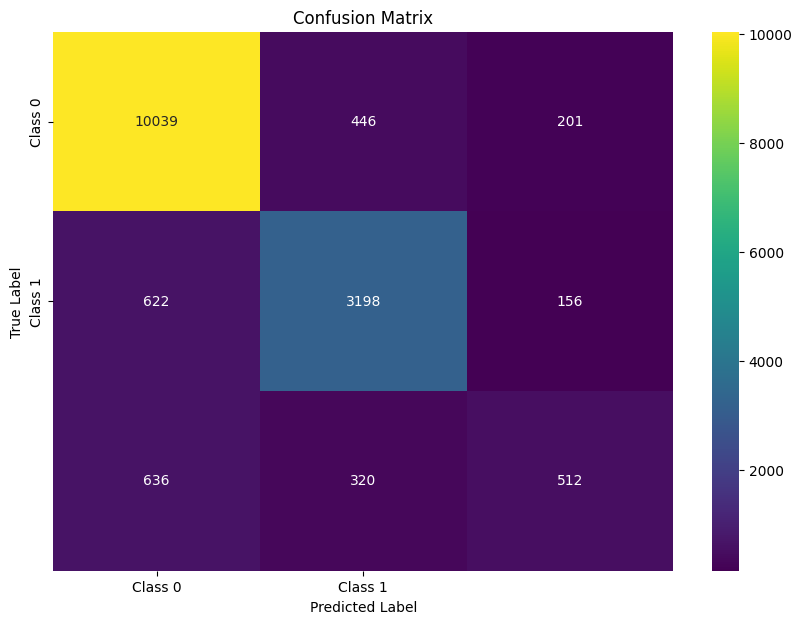

In [ ]:
conf_matrix = confusion_matrix(new_y_test, new_y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Optimal', 'Semi-Optimal', 'Poor'],
            yticklabels=['Optimal', 'Semi-Optimal', 'Poor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

The output shows the performance of a classification model on a test set. The model achieved an accuracy of 0.85, meaning it correctly predicted the outcome for 85% of the test data. This is further supported by the validation accuracy scores, which indicate consistent performance across 9-fold cross-validation, with individual fold accuracies ranging from around 0.847 to 0.857, and an overall mean accuracy of 0.85. The cross-validation standard deviation is 0.00, indicating extremely stable accuracy across all folds.

# **Using TF - IDF method for NLP**

# TF-IDF (Term Frequency-Inverse Document Frequency) is a technique used in Natural Language Processing (NLP) to evaluate how important a word is within a document relative to a collection of documents (corpus). It balances two key factors:

Term Frequency (TF): Measures how frequently a word appears in a document. Words that appear more often have a higher term frequency.
   
   -TF = (Number of times word appears in a document) / (Total words in the document)

Inverse Document Frequency (IDF): Reduces the weight of words that appear in many documents, as common words (like "the", "is") are less informative.
  
   -IDF = log(Total number of documents / Number of documents containing the word)


The final TF-IDF score is calculated by multiplying TF and IDF. Words with higher TF-IDF scores are more unique and important to the document, while common words across the corpus receive lower scores.



In [24]:
data = pd.read_csv('drugsComTrain_raw.tsv',sep='\t')

In [25]:
data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [26]:
data = data.drop(columns=['Unnamed: 0','drugName','condition','date','usefulCount'])

In [27]:
data.head()

,review,rating
0,"""It has no side effect, I take it in combinati...",9.0
1,"""My son is halfway through his fourth week of ...",8.0
2,"""I used to take another oral contraceptive, wh...",5.0
3,"""This is my first time using any form of birth...",8.0
4,"""Suboxone has completely turned my life around...",9.0


# repeating text preprocessing

### Using Label Encoder to Rating

In [28]:
data['rating'] = data['rating'].apply(convert_rating_to_class)

In [29]:
data.head()

,review,rating
0,"""It has no side effect, I take it in combinati...",Optimal Medicine
1,"""My son is halfway through his fourth week of ...",Optimal Medicine
2,"""I used to take another oral contraceptive, wh...",Semi-Optimal Medicine
3,"""This is my first time using any form of birth...",Optimal Medicine
4,"""Suboxone has completely turned my life around...",Optimal Medicine


In [30]:
lec = LabelEncoder()
data['rating'] = lec.fit_transform(data['rating'])

In [31]:
data['review'] = data['review'].apply(remove_punctuation)

# Conberting text to lowercase

In [32]:
data['review'] = data['review'].str.lower()

# removing punctations

In [33]:
data['review'] = data['review'].apply(remove_pronoun)

In [34]:
data['review'] = data['review'].apply(handling_pattern)

# converting to base word

In [35]:
data['review'] = data['review'].apply(converting_to_base_word)

In [36]:
lbe = LabelEncoder()
data['rating'] = lbe.fit_transform(data['rating'])

In [52]:
data.head()

,review,rating
0,ha no side effect take in combination of bysto...,0
1,son is halfway through fourth week of intuniv ...,0
2,used to take another oral contraceptive which ...,2
3,this is first time using any form of birth con...,0
4,suboxone ha completely turned life around feel...,0


# This code performs text classification using a TF-IDF Vectorizer to transform text data into numerical features, and then trains a Logistic Regression model to predict the ratings based on text reviews. It uses GridSearchCV for hyperparameter tuning to find the best set of parameters, and evaluates the model's accuracy.

**1. Data Preparation:**


X = data['review']

y = data['rating']

X: The feature set, which contains the text reviews from the review column.

y: The target variable, which contains the ratings corresponding to each review in the rating column.

**2.Building Pipeline**
Pipeline: Combines two key steps into a sequential pipeline for automation:

TfidfVectorizer: Converts the text reviews into TF-IDF features (numerical representation of text data based on term frequency-inverse document frequency).

LogisticRegression: Trains a logistic regression classifier with the following

 parameters:

penalty='l2': L2 regularization to prevent overfitting.

max_iter=10000: Maximum number of iterations allowed for the solver to converge.

C=0.5: Inverse regularization strength (lower value means stronger regularization).

n_jobs=-1: Use all available processors for faster computation.

multi_class='ovr': Uses the One-vs-Rest strategy for multiclass classification.


**3. Hyperparameter Tuning with Grid Search:**

**Parameter Grid (param_grid)**:

*ngram_range*: Considers different ranges of n-grams (1-2, 2-2, and 2-3 word sequences) for feature extraction.

*min_df*: Minimum document frequency; controls how frequently a term must appear across documents to be included as a feature.

*max_features*: The maximum number of features (terms) to be included in the TF-IDF vectorizer.


**GridSearchCV**: Performs an exhaustive search over the specified hyperparameter grid to find the best combination of parameters.

*cv=5*: Uses 5-fold cross-validation to evaluate the model performance for each parameter combination.

*scoring='accuracy'*: Optimizes the model based on accuracy.


**4. Best Parameters and Accuracy from Grid Search:**

*grid_search.best_params*_: Displays the best combination of hyperparameters found during the grid search.

*grid_search.best_score_*: Shows the highest cross-validated accuracy achieved during the grid search.

**5. Model Prediction and Evaluation:**

*y_pred*: Predicts the ratings for the test set using the best model found by grid search.

*accuracy_score*: Computes the accuracy of the model on the test data (percentage of correct predictions).



In [ ]:
X = data['review']
y = data['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('logistic', LogisticRegression(penalty='l2', max_iter=10000, C=0.5, fit_intercept=True, n_jobs=-1, multi_class='ovr'))
])

param_grid = {
    'tfidf_vectorizer__ngram_range': [(1, 2), (2, 2), (2, 3)],
    'tfidf_vectorizer__min_df': [0.0, 0.001, 0.01],
    'tfidf_vectorizer__max_features': [10000, 20000, 30000]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Best parameters: {'tfidf_vectorizer__max_features': 30000, 'tfidf_vectorizer__min_df': 0.0, 'tfidf_vectorizer__ngram_range': (1, 2)}
Best accuracy: 0.8123264801649569
Test Accuracy: 0.81


In [67]:
data.head()

,review,rating
0,ha no side effect take in combination of bysto...,0
1,son is halfway through fourth week of intuniv ...,0
2,used to take another oral contraceptive which ...,2
3,this is first time using any form of birth con...,0
4,suboxone ha completely turned life around feel...,0


# Creating a separate dataframe for TF-IDF vectorized review feature

In [37]:
def document_vectorization(data):

    bow = CountVectorizer(max_features= 30000, ngram_range = (1, 2),min_df = 0.0)

    arr = bow.fit_transform(data)
    print(bow.vocabulary_)

    return pd.DataFrame.sparse.from_spmatrix(arr, columns=bow.vocabulary_)

tfidf_vectorised_review = document_vectorization(data['review'])

{'ha': 10938, 'no': 16888, 'side': 21858, 'effect': 8042, 'take': 23557, 'in': 12919, 'combination': 5752, 'of': 17595, 'bystolic': 5171, 'mg': 15801, 'and': 1904, 'fish': 9459, 'oil': 18072, 'ha no': 10996, 'no side': 16986, 'side effect': 21862, 'effect take': 8129, 'take in': 23619, 'in combination': 12987, 'combination of': 5754, 'mg and': 15806, 'fish oil': 9460, 'son': 22587, 'is': 13522, 'halfway': 11347, 'through': 25747, 'fourth': 9977, 'week': 28222, 'intuniv': 13491, 'became': 3895, 'concerned': 5880, 'when': 28616, 'began': 4220, 'this': 25459, 'last': 14317, 'started': 22816, 'taking': 23714, 'the': 24358, 'highest': 12107, 'dose': 7598, 'will': 28906, 'be': 3764, 'on': 18116, 'for': 9594, 'two': 26994, 'day': 6535, 'could': 6140, 'hardly': 11420, 'get': 10313, 'out': 18937, 'bed': 3990, 'wa': 27638, 'very': 27443, 'cranky': 6338, 'slept': 22148, 'nearly': 16596, 'hour': 12274, 'drive': 7774, 'home': 12144, 'from': 10031, 'school': 21446, 'vacation': 27398, 'unusual': 2716

In [39]:
y = data['rating']

In [40]:
data.head()

,review,rating
0,ha no side effect take in combination of bysto...,0
1,son is halfway through fourth week of intuniv ...,0
2,used to take another oral contraceptive which ...,2
3,this is first time using any form of birth con...,0
4,suboxone ha completely turned life around feel...,0


In [41]:
data = data.drop(columns='review')
data = data.drop(columns='rating')

In [42]:
data = tfidf_vectorised_review

In [43]:
X_train,X_test,y_train,y_test = train_test_split(data,y,random_state=42,test_size=0.1,stratify = y)

# Using the best parameters achieved through GridSearchCV, and running the model again

**1.Logistic Regression Model Initialization:**

**The LogisticRegression model is instantiated with the following parameters**:

*penalty='l2'*: Applies L2 regularization to avoid overfitting.

*max_iter=10000*: Sets the maximum number of iterations to ensure convergence during training.

*C=0.5*: Controls regularization strength (smaller values indicate stronger regularization).

*n_jobs=-1*: Uses all available CPU cores to speed up computations.

multi_class='ovr': Uses the One-vs-Rest strategy for multiclass classification.


**2.K-Fold Cross-Validation Setup**

A KFold cross-validator is created with 9 splits (n_splits=9), shuffling the data and using a random state of 42 for reproducibility.

**3.Performance Metrics**:

*Accuracy*: The proportion of correct predictions.

*Precision (weighted)*: The proportion of true positive predictions out of all positive predictions, averaged over all classes with consideration for class imbalance.

*Recall (weighted)*: The proportion of actual positive instances correctly identified, averaged across classes.

*F1 Score (weighted)*: The harmonic mean of precision and recall, providing a balanced measure of the model's classification performance.




In [ ]:
lgr = LogisticRegression(penalty='l2', max_iter=10000, C=0.5, fit_intercept=True, n_jobs=-1, multi_class='ovr')

kf = KFold(n_splits=9, shuffle=True, random_state=42)

cv_scores = cross_val_score(lgr, X_train, y_train, cv=kf, scoring='accuracy')

lgr.fit(X_train, y_train)

y_pred = lgr.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Validation Accuracy Scores: {cv_scores}")
print(f"Validation Mean Accuracy: {cv_scores.mean():.2f}")

print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Validation Accuracy Scores: [0.85083695 0.84761314 0.84699318 0.84965902 0.85145691 0.85461872
 0.8519437  0.85584971 0.8504557 ]
Validation Mean Accuracy: 0.85
Test Accuracy: 0.86
Test Precision: 0.85
Test Recall: 0.86
Test F1 Score: 0.85


# **ACCURACY:**

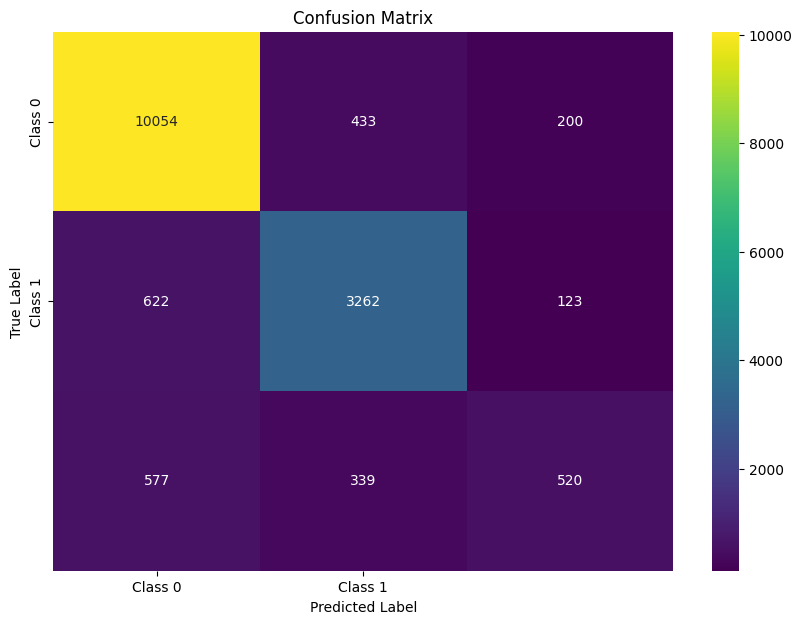

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Optimal', 'Semi-Optimal', 'Poor'],
            yticklabels=['Optimal', 'Semi-Optimal', 'Poor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# **BAG OF WORDS VS TF-IDF**


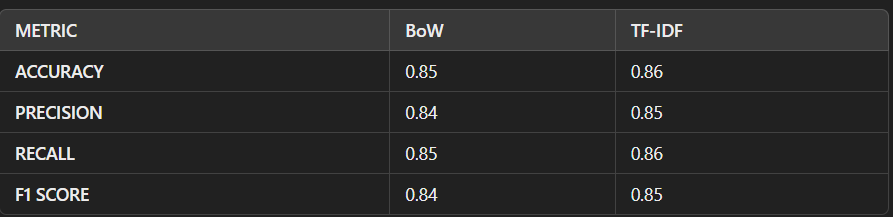

# **1.USING RANDOM FOREST CLASSIFER**


*Random Forest Classifier Initialization:*

RandomForestClassifier is initialized with the following parameters:

n_estimators=800: The number of trees in the forest is set to 800.

max_depth=None
min_samples_leaf=1: Each leaf node must have at least one sample.
max_features='log2': The maximum number of features considered for splitting at each node is based on the log base 2 of the total number of features.
random_state=42: Sets a random seed for reproducibility.

Note: here we removed validation as it was requiring too much processing time

*MODEL EVALUATION*:

Accuracy: The proportion of correct predictions.
Precision: The proportion of true positive predictions out of all positive predictions, averaged over all classes with consideration for class imbalance.
Recall  The proportion of actual positive instances correctly identified, averaged across classes.
F1 Score : The harmonic mean of precision and recall, providing a balanced measure of the model's classification performance.

In [50]:
rfc = RandomForestClassifier(n_estimators=800, max_depth=None, random_state=42, min_samples_leaf=1,max_features='log2',n_jobs=-1)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")

Test Accuracy: 0.87
Test Precision: 0.89
Test Recall: 0.87
Test F1 Score: 0.86


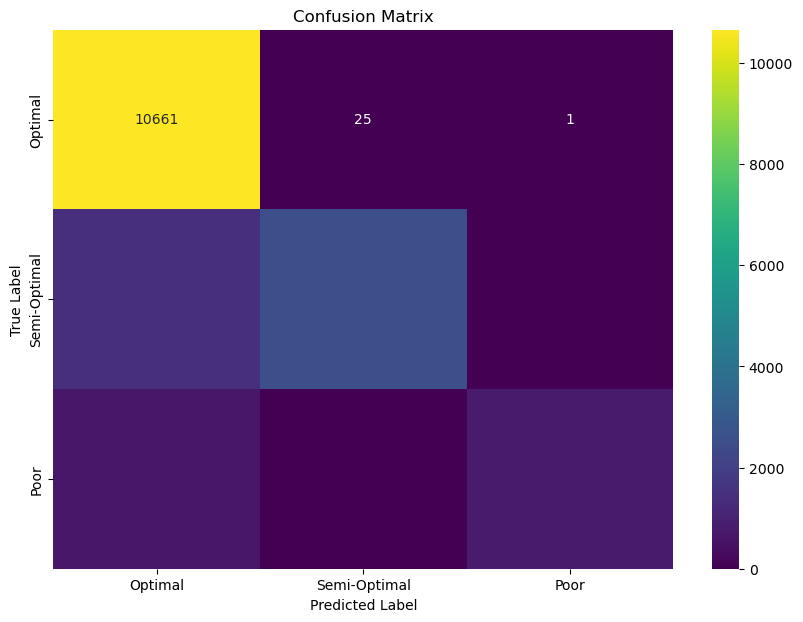

In [51]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Optimal', 'Semi-Optimal', 'Poor'],
            yticklabels=['Optimal', 'Semi-Optimal', 'Poor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# **FEATURE IMPORTANCE** *using random forest classifier*

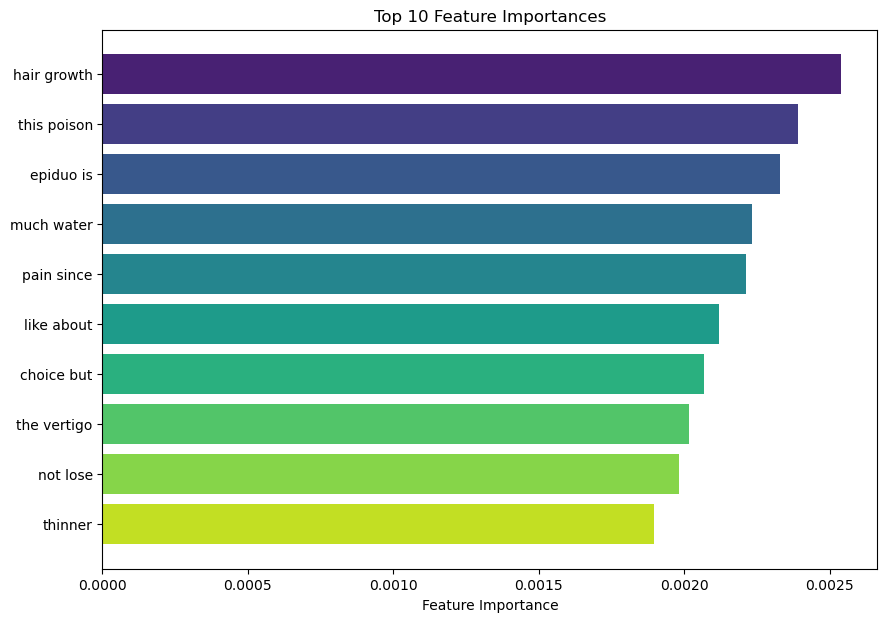

In [59]:
features = rfc.feature_importances_
feature_name = np.array(X_train.columns)

sorted_features = sorted(enumerate(features), key=lambda x: x[1], reverse=True)

top_10 = sorted_features[:10]
top_important_feature = [x[1] for x in top_10]
top_feature_indices = [x[0] for x in top_10]
top_important_feature_name = feature_name[top_feature_indices]

colors = sns.color_palette('viridis', len(top_important_feature))

plt.figure(figsize=(10, 7))
plt.barh(top_important_feature_name, top_important_feature, color=colors)
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.show()


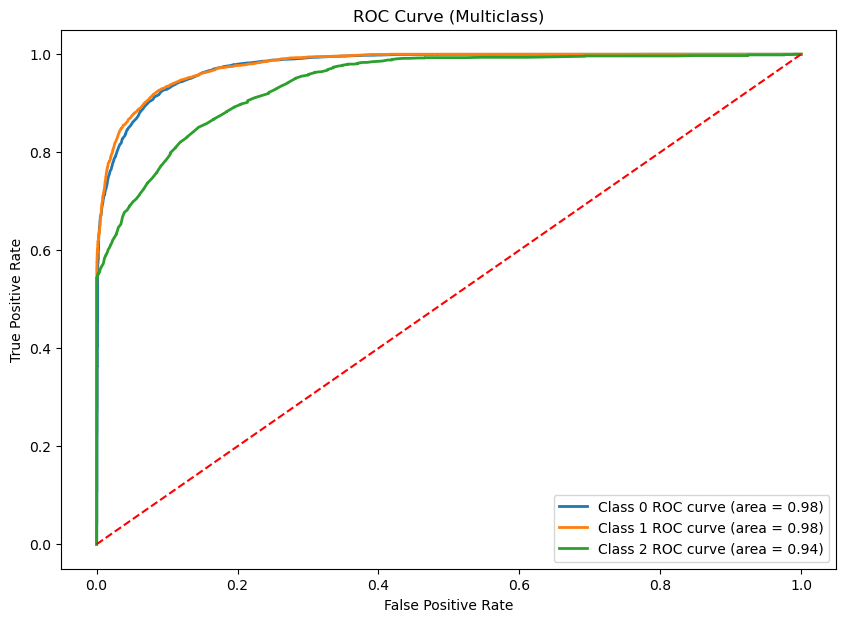

In [66]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2]) 
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

y_prob = rfc.predict_proba(X_test)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {} ROC curve (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multiclass)')
plt.legend(loc='lower right')
plt.show()


# **2.USING Gaussian Naive Bayes CLASSIFIER**


In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

dtc = DecisionTreeClassifier(random_state=42, max_depth=None, min_samples_leaf=1, max_features='log2')

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1 Score: {f1:.2f}")


Test Accuracy: 0.81
Test Precision: 0.81
Test Recall: 0.81
Test F1 Score: 0.81


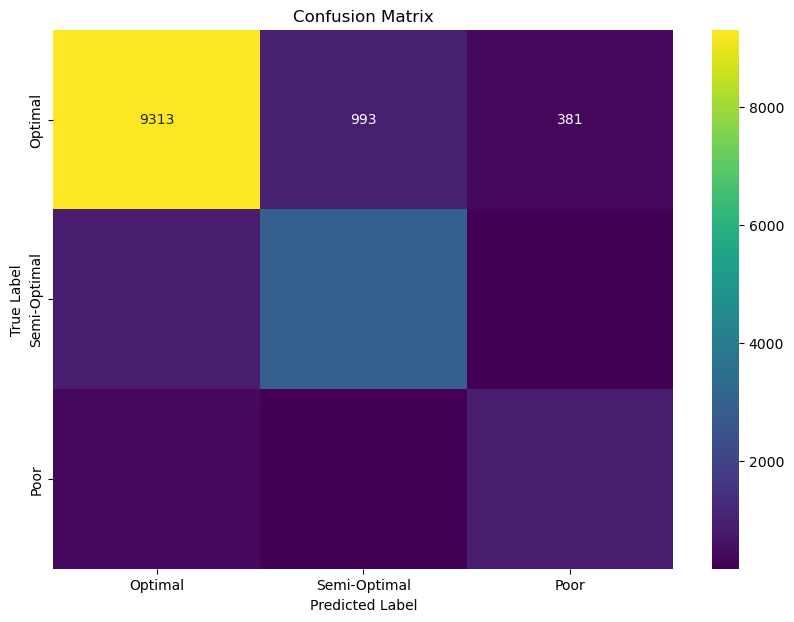

In [54]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Optimal', 'Semi-Optimal', 'Poor'],
            yticklabels=['Optimal', 'Semi-Optimal', 'Poor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

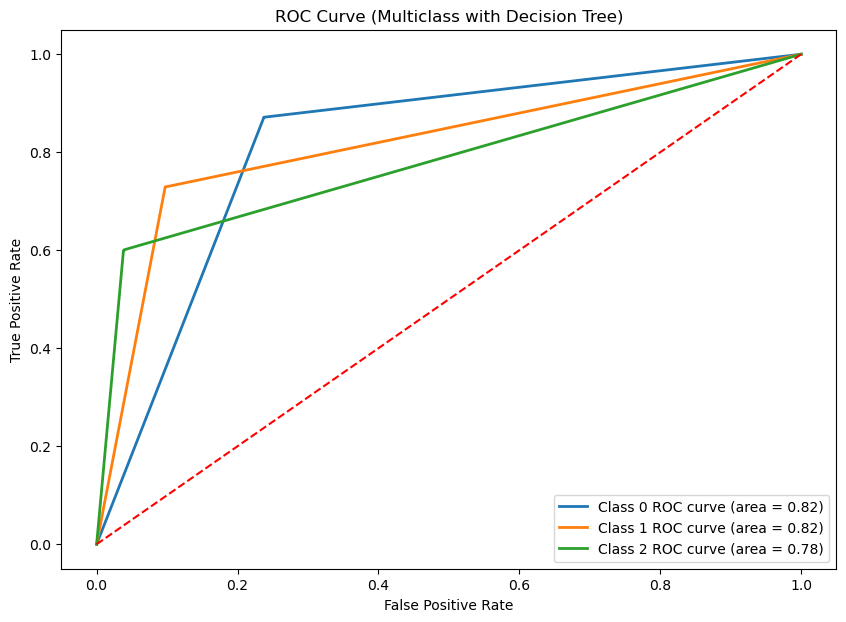

In [57]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

y_pred_proba = dtc.predict_proba(X_test) 

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {} ROC curve (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='red', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multiclass with Decision Tree)')
plt.legend(loc='lower right')

plt.show()
